# Q1:

<ipython-input-2-fd31a05b0cc6>:19: RuntimeWarning: divide by zero encountered in scalar divide
  return np.prod(stats.norm(loc=theta[c,g-1], scale=1/(tau_)**0.5).pdf(x)) * \
<ipython-input-2-fd31a05b0cc6>:25: RuntimeWarning: invalid value encountered in scalar divide
  mh_calc = (tau_target(tau_tilde) / tau_target(tau[c,g-1])) * \


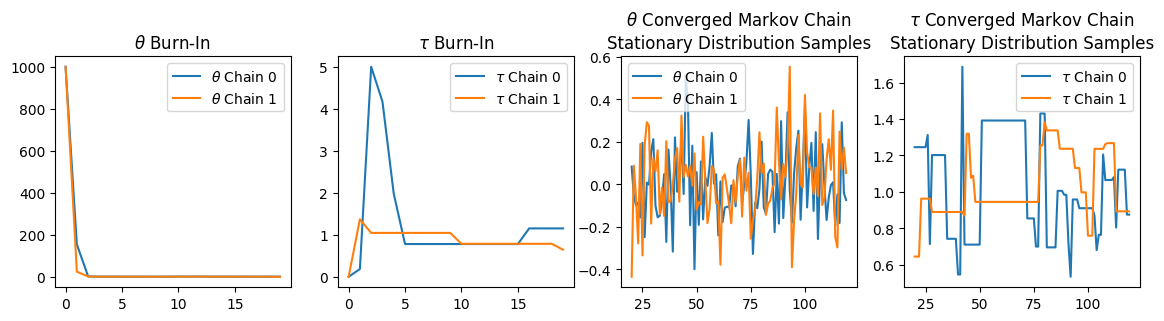

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# loc is mean and scale is standard deviation
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C, G = 2, 10000  # chains, Gibbs samples

theta, tau = np.zeros([C,G]), np.zeros([C,G])
theta[:,0] = 1000  # initialization

alpha = 2  # Hyperparameter for Gamma prior
lambda_param = 1  # Hyperparameter for Gamma prior

for c in range(C):
    for g in range(1, G):
        # Metropolis-Hastings step for tau
        def tau_target(tau_):
            return np.prod(stats.norm(loc=theta[c,g-1], scale=1/(tau_)**0.5).pdf(x)) * \
                   stats.expon(scale=1).pdf(tau_)  # Prior for tau (exponential)

        tau_proposal = stats.expon(scale=2)  # Proposal distribution
        tau_tilde = tau_proposal.rvs()

        mh_calc = (tau_target(tau_tilde) / tau_target(tau[c,g-1])) * \
                  (tau_proposal.pdf(tau[c,g-1]) / tau_proposal.pdf(tau_tilde))

        acceptance_probability = min(1, mh_calc)
        if stats.uniform().rvs() < acceptance_probability:
            tau[c,g] = tau_tilde
        else:
            tau[c,g] = tau[c,g-1]

        # Gibbs sampling step for theta
        tau_factor = tau[c, g] * n
        mean_theta = (np.mean(x) * tau_factor + theta[c, g - 1]) / (tau_factor + 1)
        std_theta = (1 / (tau_factor + 1)) ** 0.5
        theta[c, g] = stats.norm(loc=mean_theta, scale=std_theta).rvs()

# Plot results
fig, ax = plt.subplots(1, 4, figsize=(14,3))
ax[0].set_title("$\\theta$ Burn-In")
ax[1].set_title("$\\tau$ Burn-In")
ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

burn = 20
demo = 120

for c in range(C):
    ax[0].plot(theta[c, :burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c, :burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c, burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c, burn:demo], label="$\\tau$ Chain "+str(c))

ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();
plt.show()


# Q2:
## Choose Gamma distribution as prior distribution


<ipython-input-4-6bb637a304aa>:32: RuntimeWarning: invalid value encountered in scalar power
  return np.prod(stats.norm(loc=theta[c, g - 1], scale=1/(tau_)**0.5).pdf(x)) * \


Iteration 1000, Chain 0: tau = 1.4399266265926047, theta_scale = 0.022625561163699192
Iteration 2000, Chain 0: tau = 1.3117108664422918, theta_scale = 0.024782333055593162
Iteration 3000, Chain 0: tau = 1.7661076251596066, theta_scale = 0.01852427176118661
Iteration 4000, Chain 0: tau = 1.3422678428327168, theta_scale = 0.024231829625383828
Iteration 5000, Chain 0: tau = 1.342559176938757, theta_scale = 0.024226698731532072
Iteration 6000, Chain 0: tau = 1.1586024369675734, theta_scale = 0.027965712720340846
Iteration 7000, Chain 0: tau = 1.582076930486938, theta_scale = 0.020634593007044285
Iteration 8000, Chain 0: tau = 1.3763625201787963, theta_scale = 0.023645762488615076
Iteration 9000, Chain 0: tau = 1.4653529094118767, theta_scale = 0.022241702354106614
Iteration 1000, Chain 1: tau = 1.2831298045940027, theta_scale = 0.025320369688295225
Iteration 2000, Chain 1: tau = 1.1008510385478534, theta_scale = 0.029389695502544992
Iteration 3000, Chain 1: tau = 1.6932066037409965, theta_

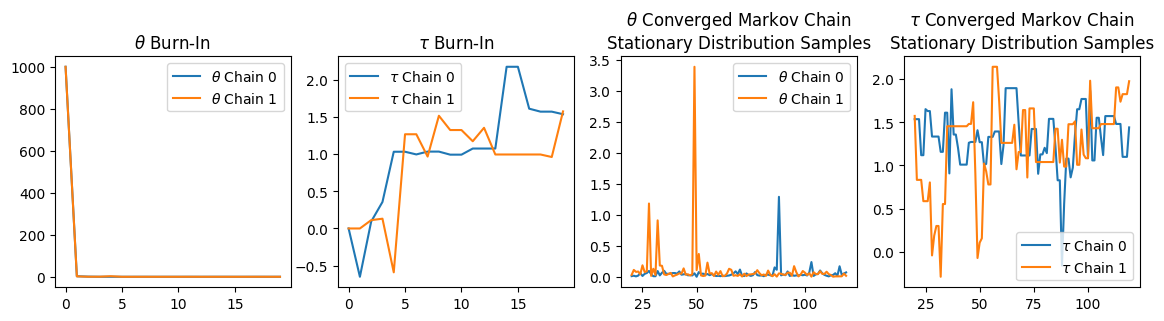

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# loc is mean and scale is standard deviation
n = 30
x = stats.norm(loc=0, scale=1).rvs(size=n)  # Generate observed data
C, G = 2, 10000  # Number of chains and Gibbs samples

theta, tau = np.zeros([C, G]), np.zeros([C, G])  # Initialize storage arrays
theta[:, 0] = 1000  # Initialize theta values

alpha = 2  # Hyperparameter for the Gamma prior
lambda_param = 1  # Hyperparameter for the Gamma prior
s = 1  # Scale parameter for truncated normal proposal in Metropolis-Hastings

for c in range(C):
    for g in range(1, G):
        # ---- Metropolis-Hastings step for tau ----
        tau_t_minus_1 = tau[c, g - 1]

        # Ensure tau_t_minus_1 is non-negative to avoid issues in proposal computation
        tau_t_minus_1 = max(tau_t_minus_1, 1e-6)

        # Define truncated normal proposal distribution for tau
        a, b = (tau_t_minus_1 - 1/s - tau_t_minus_1) / s, (np.inf - tau_t_minus_1) / s
        tau_proposal = stats.truncnorm(a, b, loc=tau_t_minus_1, scale=s)
        tau_tilde = tau_proposal.rvs()

        # Define the target distribution for tau
        def tau_target(tau_):
            return np.prod(stats.norm(loc=theta[c, g - 1], scale=1/(tau_)**0.5).pdf(x)) * \
                   stats.expon(scale=1).pdf(tau_)  # Prior for tau

        # Compute the Metropolis-Hastings acceptance ratio
        mh_calc = (tau_target(tau_tilde) / tau_target(tau_t_minus_1)) * \
                  (tau_proposal.pdf(tau_t_minus_1) / tau_proposal.pdf(tau_tilde))

        # Compute acceptance probability
        acceptance_probability = min(1, mh_calc)

        # Accept or reject the proposed tau
        if stats.uniform().rvs() < acceptance_probability:
            tau[c, g] = tau_tilde
        else:
            tau[c, g] = tau_t_minus_1

        # ---- Gibbs sampling step for theta (using a Gamma prior) ----
        theta_shape = 2.0  # Shape parameter for Gamma distribution
        theta_scale = 1.0 / (max(tau[c, g], 1e-6) * n + 1)  # Scale parameter for Gamma

        # Ensure theta_scale is positive to avoid errors in Gamma sampling
        theta_scale = max(theta_scale, 1e-6)

        # Debugging print to check theta_scale values (every 1000 iterations)
        if g % 1000 == 0:
            print(f"Iteration {g}, Chain {c}: tau = {tau[c, g]}, theta_scale = {theta_scale}")

        # Sample theta from Gamma distribution
        theta[c, g] = stats.gamma(a=theta_shape, scale=theta_scale).rvs()

# ---- Plot results to check convergence ----
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].set_title("$\\theta$ Burn-In")
ax[1].set_title("$\\tau$ Burn-In")
ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

burn = 20  # Burn-in period
demo = 120  # Number of samples to visualize

for c in range(C):
    ax[0].plot(theta[c, :burn], label="$\\theta$ Chain " + str(c))
    ax[1].plot(tau[c, :burn], label="$\\tau$ Chain " + str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c, burn:demo], label="$\\theta$ Chain " + str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c, burn:demo], label="$\\tau$ Chain " + str(c))

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
plt.show()



# Q3:
In the Metropolis-Hastings algorithm, the acceptance probability is given by:
$$
A(x^{(t-1)}, \tilde{x}^{(t)}) = \min \left( 1, \frac{p(\tilde{x}^{(t)}) q(x^{(t-1)} | \tilde{x}^{(t)})}{p(x^{(t-1)}) q(\tilde{x}^{(t)} | x^{(t-1)})} \right)
$$
We are given the following proposal distribution:
$$
q(\tilde{x}^{(t)} | x^{(t-1)}) = \left(\frac{1}{2}\right)^{1 - \tilde{x}^{(t)}} \cdot \left(\frac{1}{2}\right)^{\tilde{x}^{(t)}}
$$
And the stationary distribution:
$$
p(x^{(t)}) = \left(\frac{1}{3}\right)^{1 - x^{(t)}} \cdot \left(\frac{2}{3}\right)^{x^{(t)}}
$$
We substitute these into the acceptance probability formula:
$$
A(x^{(t-1)}, \tilde{x}^{(t)}) = \min \left( 1, \frac{\left(\frac{1}{3}\right)^{1 - \tilde{x}^{(t)}} \left(\frac{2}{3}\right)^{\tilde{x}^{(t)}} \cdot q(x^{(t-1)} | \tilde{x}^{(t)})}{\left(\frac{1}{3}\right)^{1 - x^{(t-1)}} \left(\frac{2}{3}\right)^{x^{(t-1)}} \cdot q(\tilde{x}^{(t)} | x^{(t-1)})} \right)
$$
As both ${q(x^{(t-1)} | \tilde{x}^{(t)})}$ and ${q(\tilde{x}^{(t)} | x^{(t-1)})}$ both follow uniform distribution (q = 1/2), which is a symmetric proposal distribution.The proposal probabilities therefore cancel out, and the acceptance ratio depends only on the target distribution p(x).
$$
\frac{q(x^{(t-1)} | \tilde{x}^{(t)})}{q(\tilde{x}^{(t)} | x^{(t-1)})} = 1
$$
$$
A(x^{(t-1)}, \tilde{x}^{(t)}) = \min \left( 1, \frac{p(\tilde{x}^{(t)})}{p(x^{(t-1)})} \right)
$$

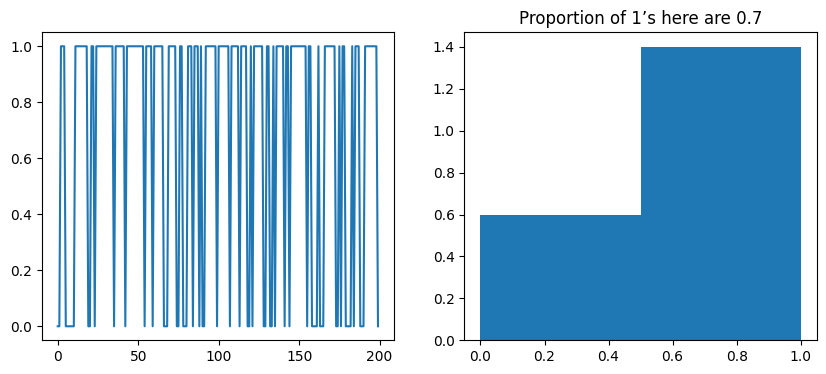

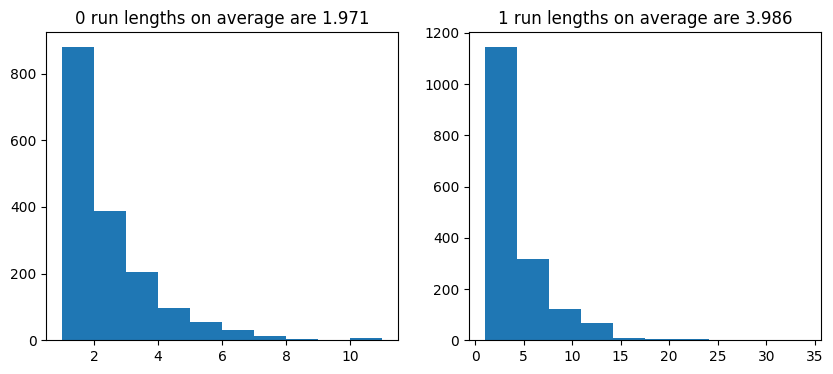

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Define the transition matrix K
K = np.array([[0.5, 0.25],  # P(0 -> 0) = 0.5, P(1 -> 0) = 0.25
              [0.5, 0.75]])  # P(0 -> 1) = 0.5, P(1 -> 1) = 0.75

# ---- Simulation 1: Small T for quick visualization ----
T = 200
s_t = np.zeros(T, dtype=int)  # Initialize state sequence
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:, s_t[t-1]][1])

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1’s here are " + str(s_t.mean()))

# ---- Simulation 2: Large T to analyze state run lengths ----
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:, s_t[t-1]][1])

# Compute run lengths of 0s and 1s
state0_run_length = []
state1_run_length = []
run_length = 1

for t in range(1, T):
    if s_t[t] == s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length.append(run_length)
        else:
            state1_run_length.append(run_length)
        run_length = 1  # Reset counter

# Plot histograms of run lengths
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on average are " + str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on average are " + str(np.mean(state1_run_length).round(3)))
plt.show()
